In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

from scipy.stats import pearsonr

### Simple RF model
We take the features of the mixtrues, concatenate them for the two mixtures of a training example and predict the target variable (similarity).

TODO: as test mixtures are new (not present in train / leaderboard), some mixture exclusive testing would be interesting

In [150]:
### we make a zscore normalization of the features, some models like it
features = pd.read_csv('../results/features/mix-descriptors-v1.csv', index_col=0)
features = (features - features.mean()) / features.std()

In [151]:
train = pd.read_csv('../data/olfaction_mixture/TrainingData_mixturedist.csv')
fil = train.isna().sum(1) == 0
train = train[fil]
train['Mixture 1'] = train['Dataset'].astype(str) + '_' + train['Mixture 1'].astype(int).astype(str)
train['Mixture 2'] = train['Dataset'].astype(str) + '_' + train['Mixture 2'].astype(int).astype(str)
del train['Dataset']
train['Name'] = train['Mixture 1'] + ' / ' + train['Mixture 2']
train.head()

,Mixture 1,Mixture 2,Experimental Values,Name
0,Snitz 1_1,Snitz 1_2,0.604167,Snitz 1_1 / Snitz 1_2
1,Snitz 1_1,Snitz 1_3,0.651042,Snitz 1_1 / Snitz 1_3
2,Snitz 1_1,Snitz 1_5,0.505208,Snitz 1_1 / Snitz 1_5
3,Snitz 1_1,Snitz 1_6,0.411458,Snitz 1_1 / Snitz 1_6
4,Snitz 1_1,Snitz 1_7,0.562500,Snitz 1_1 / Snitz 1_7


In [152]:
tr = np.random.choice(train.index, 400, False).tolist()
ts = list(set(train.index) - set(tr))
len(tr), len(ts)

(400, 100)

In [153]:
data_tr = train.loc[tr]
data_ts = train.loc[ts]

In [154]:
### we will duplicate the dataset to make it invariant to the orders of mixture 1 / 2
def duplicate_dataset(data):
    data_ = data.copy()
    data_['Mixture 1'] = data['Mixture 2']
    data_['Mixture 2'] = data['Mixture 1']
    data_ = pd.concat([data, data_])
    data_.index = range(len(data_))
    return data_

In [155]:
data_tr = duplicate_dataset(data_tr)
data_ts = duplicate_dataset(data_ts)

In [157]:
### features of the first mixture
X_tr1 = features.loc[data_tr['Mixture 1'].values]
X_tr1.index = data_tr.index
### features of the second mixture
X_tr2 = features.loc[data_tr['Mixture 2'].values]
X_tr2.index = data_tr.index

X_tr = pd.concat([X_tr1, X_tr2], axis=1)

In [158]:
### same for test
X_ts1 = features.loc[data_ts['Mixture 1'].values]
X_ts1.index = data_ts.index

X_ts2 = features.loc[data_ts['Mixture 2'].values]
X_ts2.index = data_ts.index

X_ts = pd.concat([X_ts1, X_ts2], axis=1)

In [159]:
model = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model.fit(X_tr, data_tr['Experimental Values'])

RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [160]:
y_pr = model.predict(X_ts)
data_ts['pred'] = y_pr

In [161]:
### average the 2 predictions for each mixture
results = data_ts[['Name', 'Experimental Values', 'pred']].groupby('Name').mean()

PearsonRResult(statistic=0.45535327816900206, pvalue=1.9349757628327474e-06)

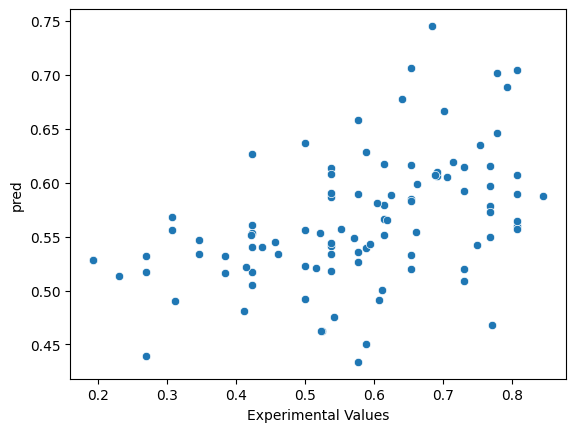

In [162]:
sns.scatterplot(x=results['Experimental Values'],
               y=results['pred'])
pearsonr(x=results['Experimental Values'],
               y=results['pred'])

looks okayish, so let's do the prediction for leaderboard and test sets.

### Pred for leaderboard and test

In [163]:
lead = pd.read_csv('../data/olfaction_mixture/Leaderboard_set_Submission_form.csv')
lead['Mixture 1'] = lead['Dataset'].astype(str) + '_' + lead['Mixture_1'].astype(int).astype(str)
lead['Mixture 2'] = lead['Dataset'].astype(str) + '_' + lead['Mixture_2'].astype(int).astype(str)
del lead['Dataset']
del lead['Mixture_1']
del lead['Mixture_2']
lead['Name'] = lead['Mixture 1'] + ' / ' + lead['Mixture 2']
lead.head()

,Predicted_Experimental_Values,Mixture 1,Mixture 2,Name
0,0,Bushdid_65,Bushdid_66,Bushdid_65 / Bushdid_66
1,0,Snitz 2_1,Snitz 2_8,Snitz 2_1 / Snitz 2_8
2,0,Snitz 1_24,Snitz 1_17,Snitz 1_24 / Snitz 1_17
3,0,Snitz 2_12,Snitz 2_14,Snitz 2_12 / Snitz 2_14
4,0,Snitz 1_49,Snitz 1_45,Snitz 1_49 / Snitz 1_45


In [164]:
test = pd.read_csv('../data/olfaction_mixture/Test_set_Submission_form.csv')
test['Mixture 1'] = test['Mixture_1'].astype(int).astype(str)
test['Mixture 2'] = test['Mixture_2'].astype(int).astype(str)
del test['Dataset']
del test['Mixture_1']
del test['Mixture_2']
test['Name'] = test['Mixture 1'] + ' / ' + test['Mixture 2']
test.head()

,Predicted_Experimental_Values,Mixture 1,Mixture 2,Name
0,0,1,17,1 / 17
1,0,2,18,2 / 18
2,0,3,19,3 / 19
3,0,4,20,4 / 20
4,0,5,21,5 / 21


In [166]:
train = duplicate_dataset(train)
lead = duplicate_dataset(lead)
test = duplicate_dataset(test)

In [168]:
### train features
X_tr1 = features.loc[train['Mixture 1'].values]
X_tr1.index = train.index

X_tr2 = features.loc[train['Mixture 2'].values]
X_tr2.index = train.index

X_tr = pd.concat([X_tr1, X_tr2], axis=1)

In [169]:
### leaderoard features
X_lb1 = features.loc[lead['Mixture 1'].values]
X_lb1.index = lead.index

X_lb2 = features.loc[lead['Mixture 2'].values]
X_lb2.index = lead.index

X_lb = pd.concat([X_lb1, X_lb2], axis=1)

In [170]:
### test features
X_ts1 = features.loc[test['Mixture 1'].values]
X_ts1.index = test.index

X_ts2 = features.loc[test['Mixture 2'].values]
X_ts2.index = test.index

X_ts = pd.concat([X_ts1, X_ts2], axis=1)

In [175]:
model = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model.fit(X_tr, train['Experimental Values'])

RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [177]:
lead['Predicted_Experimental_Values'] = model.predict(X_lb)
test['Predicted_Experimental_Values'] = model.predict(X_ts)

In [179]:
lead = lead[['Name', 'Predicted_Experimental_Values']].groupby('Name').mean()
test = test[['Name', 'Predicted_Experimental_Values']].groupby('Name').mean()

Now let's do the submission files.

In [206]:
sub_lead = pd.read_csv('../data/olfaction_mixture/Leaderboard_set_Submission_form.csv')
sub_test = pd.read_csv('../data/olfaction_mixture/Test_set_Submission_form.csv')

In [207]:
sub_lead.index = sub_lead['Dataset'] + '_' + sub_lead['Mixture_1'].astype(str) + ' / ' + sub_lead['Dataset'] + '_' + sub_lead['Mixture_2'].astype(str)
sub_test.index = sub_test['Mixture_1'].astype(str) + ' / ' + sub_test['Mixture_2'].astype(str)

In [208]:
sub_lead['Predicted_Experimental_Values'] = lead.loc[sub_lead.index]['Predicted_Experimental_Values']
sub_test['Predicted_Experimental_Values'] = test.loc[sub_test.index]['Predicted_Experimental_Values']

In [210]:
sub_lead.to_csv('../results/submissions/first-version-lead.csv', index=False)
sub_test.to_csv('../results/submissions/first-version-test.csv', index=False)